In [16]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "slumlordreach" # 21st_year, pieman, slumlordreach, black
MODEL = 'bert-large-uncased' # bert-base-uncased, bert-large-uncased || GPT: gpt2, gpt2-xl, gpt-neo-2.7B

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/slumlordreach/tr_tokens.csv
Loaded 1177 TRs.


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Layerwise Activations

In [ ]:
foo.process_stimulus_activations()

In [ ]:
foo.model_name

In [ ]:
SAVE_QKV_VECTORS = False

for layer in range(0, 12):

    layer_activations = foo.layer_activations_from_tensor(foo.stimulus_df["activations"], layer)
    layer_mean_embeddings = np.array([l.mean(0).numpy() for l in layer_activations])
    np.save("{}_{}_layer_{}_activations.npy".format(STIMULUS, MODEL, layer), layer_mean_embeddings)
    
    print(layer_mean_embeddings.shape)
    
    layer_z_reps = foo.layer_activations_from_tensor(foo.stimulus_df["z_reps"], layer)
    layer_mean_z_reps = np.array([l.mean(0).numpy() for l in layer_z_reps])
    np.save("{}_{}_layer_{}_z_representations.npy".format(STIMULUS, MODEL, layer), layer_mean_z_reps)
    
    print(layer_mean_z_reps.shape)

    if SAVE_QKV_VECTORS: 
        for representation in ["query", "key", "value"]:
            all_reps = foo.layer_activations_from_tensor(foo.stimulus_df["query"], layer)
            mean_rep = np.array([l.mean(0).numpy() for l in all_reps])
            np.save("{}_{}_layer_{}_{}.npy".format(STIMULUS, MODEL, layer, representation), mean_rep)
            print("Processed {} layer {} --> {}.".format(representation, layer, mean_rep.shape))

layer_glove = foo.layer_activations_from_tensor(foo.stimulus_df["glove"], 0)
np.save("{}_{}_layer_{}_glove.npy".format(STIMULUS, MODEL, 0), layer_glove)
#     df["layer_{}".format(layer)] = layer_mean_embeddings

# Layerwise Attentions
Important question: how many prior tokens should we take for attention metric context?

In [ ]:
print(foo.stimulus_df.n_transformer_tokens_in_tr.describe())
foo.stimulus_df.n_transformer_tokens_in_tr.hist(bins=20);
plt.suptitle("Number of Transformer Tokens per TR")
plt.xlabel("Number of Tokens");

In [ ]:
# Median number of tokens per TR is 5; 75th percentile is 7.
# Assuming we're using about 30 seconds of prior context, that's 20 TRs, so we should take 100-140 context tokens. (yikes-- we've been doing 20!)

N_ATTENTION_TOKENS = 10 # 20, 128

In [ ]:
foo.verbose = False
foo.process_stimulus_attentions(num_window_tokens=N_ATTENTION_TOKENS)

In [ ]:
print("Successfully produced attention maps for {} of {} TRs.".format( 
    len(foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]), len(foo.stimulus_df)))

In [ ]:
has_attentions = foo.stimulus_df[foo.stimulus_df.attentions.isnull()]
failed_attentions = foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]

# Masking Attention

All of the below analyses can / should be run with various parameter settings.

They run much faster than the original activation / attention code and do various masking and summarization procedures on the raw data.

In [ ]:
BACKWARD_ATTENTION = False

if BACKWARD_ATTENTION:
    ATTENTION_DIRECTION = "bck"
else:
    ATTENTION_DIRECTION = "fwd"

In [ ]:
foo.mask_non_tr_attentions(include_forwards=not BACKWARD_ATTENTION, 
                           include_backwards=BACKWARD_ATTENTION)

In [104]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p='inf')

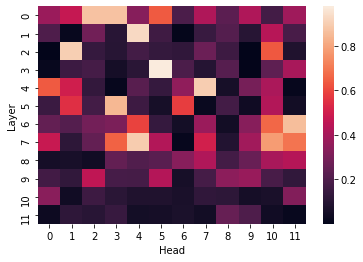

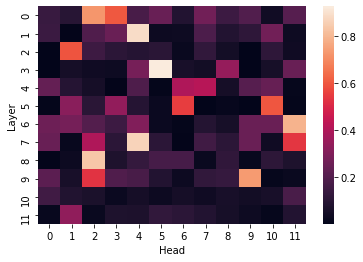

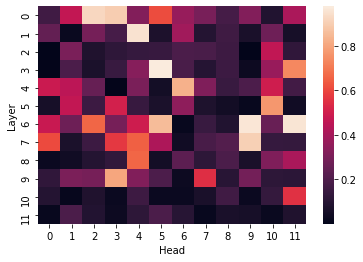

In [105]:
for x in [90, 150, 200]:
    plt.figure()
    sns.heatmap(foo.stimulus_df.attention_heads_Linf.iloc[x])
    plt.xlabel("Head")
    plt.ylabel("Layer")

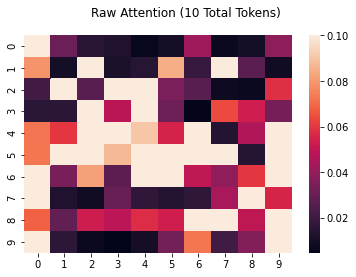

In [106]:
sns.heatmap(foo.stimulus_df.attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("Raw Attention ({} Total Tokens)".format(N_ATTENTION_TOKENS));

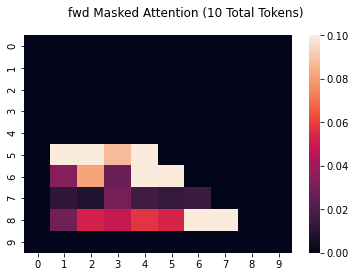

In [107]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("{} Masked Attention ({} Total Tokens)".format(ATTENTION_DIRECTION, N_ATTENTION_TOKENS));

# Outputs for Sreejan

In [111]:
import itertools

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

### Syntactic Complexity

In [112]:
for p in [1, 'inf']:  # can also do p=2, but not using that currently.

    COMPLEXITY_OUTPUT_FILE = "{}_{}_syntactic_complexity_L-{}_T-{}_D-{}.npy".format(STIMULUS, MODEL, p, N_ATTENTION_TOKENS, ATTENTION_DIRECTION)
    print("Outputting metrics to {}".format(COMPLEXITY_OUTPUT_FILE))

    attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))

    attention_np_arrays = np.array(attention_vectors)
    print(attention_np_arrays.shape)
    np.save(COMPLEXITY_OUTPUT_FILE, attention_np_arrays)


Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd.npy
(534,)
Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-fwd.npy
(534,)


### To upload to PNI

```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [156]:
import random

def concatenate_fwd_bck_arrays(fwd, bck):

    nonzero_fwd = 0
    total_fwd = 0
    nonzero_bck = 0
    total_bck = 0
    
    res = []
    for f, b in zip(fwd, bck):
        if f is None and b is None:
            res.append(None)
        else:
            if random.random() > .95:
                
                nonzero_fwd += len([v for v in f if v > 1e-5])
                total_fwd += len(f)
                nonzero_bck += len([v for v in b if v > 1e-5])
                total_bck += len(b)
                
            res.append(f + b)
    res = np.array(res, dtype=object)
    
#     print("\tFound {}/{} and {}/{} nonzero.".format(nonzero_fwd, total_fwd, nonzero_bck, total_bck))
    
    return res

In [157]:
import glob

backwards_metrics = [f for f in glob.glob("*.npy") if 'bck' in f]

for backwards_file in backwards_metrics:
    
    bck = np.load(backwards_file, allow_pickle=True)
    forward_file = backwards_file.replace("bck", "fwd")
    fwd = np.load(forward_file, allow_pickle=True)
    
    concat = concatenate_fwd_bck_arrays(fwd, bck)
    concat_file = backwards_file.replace("bck", "concat")
    
    np.save(concat_file, concat)
    
#     print(concat.shape)
#     print(len(concat[-10]))
#     print(backwards_file + "\n" + forward_file + "\n" + concat_file + "\n=======")

    

	Found 7616/7632 and 7632/7632 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-fwd.npy
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-concat.npy
	Found 3713/3744 and 3744/3744 nonzero.
(534,)
288
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-bck.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-fwd.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy
	Found 9325/9360 and 9360/9360 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy
	Found 6739/6768 and 6768/6768 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd.npy
slumlordreach_bert-base-u

In [37]:
SCP_STIMULUS='black'

ALL_SYNTAX_REPS = "scp {}_{}_syntactic_*.npy {}_{}_semantic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"

print("SCP all syntactic representations to PNI:\n")
print(ALL_SYNTAX_REPS.format(SCP_STIMULUS, MODEL, SCP_STIMULUS, MODEL, SCP_STIMULUS, MODEL))

SCP all syntactic representations to PNI:

scp black_gpt2_syntactic_*.npy black_gpt2_semantic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/gpt2/syntactic_analyses


In [38]:
ALL_LAYER_REPS = "scp {}_{}_layer_*_activations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/raw_embeddings"

print("SCP all model layers to PNI:\n")

print(ALL_LAYER_REPS.format(SCP_STIMULUS, MODEL, SCP_STIMULUS, MODEL))

SCP all model layers to PNI:

scp black_gpt2_layer_*_activations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/gpt2/raw_embeddings


# DEMO: attention distance masking
Just in case I want to double check this logic sometime.

In [5]:
import numpy as np
N_TOKENS = 5
a = np.array(range(1,N_TOKENS+1))
columns = np.tile(a,(N_TOKENS,1))
rows = np.tile(a,(N_TOKENS,1)).T
abs((rows-columns))

array([[0, 1, 2, 3, 4],
       [1, 0, 1, 2, 3],
       [2, 1, 0, 1, 2],
       [3, 2, 1, 0, 1],
       [4, 3, 2, 1, 0]])

# Computing Stimulus Statistics


slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy


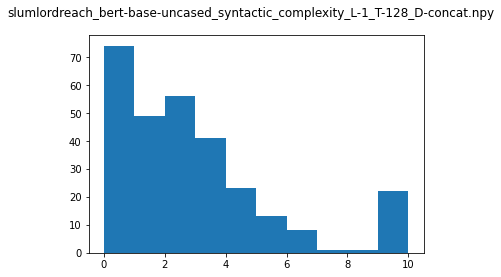


black_bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat.npy


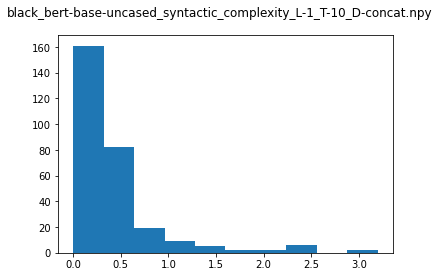


black_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy


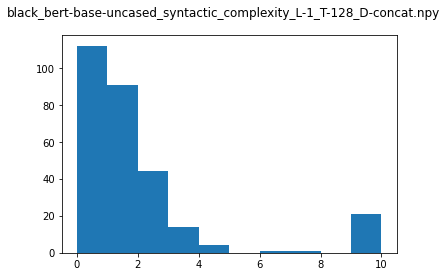


slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-concat.npy


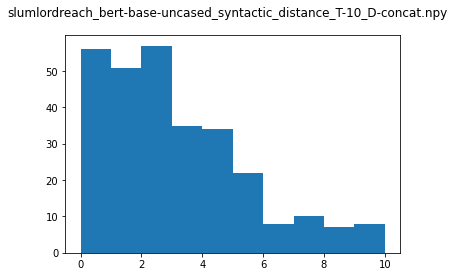


black_bert-base-uncased_syntactic_distance_T-128_D-concat.npy


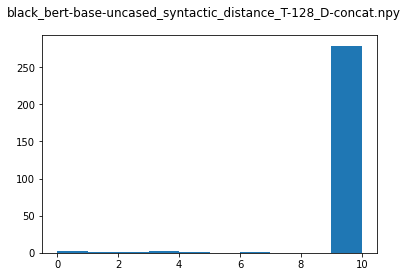


slumlordreach_bert-base-uncased_syntactic_distance_T-128_D-concat.npy


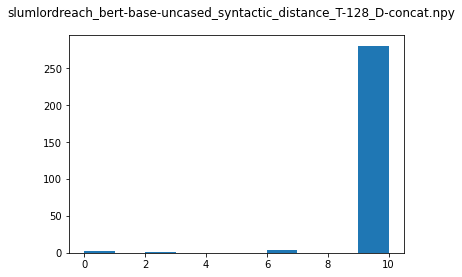


black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy


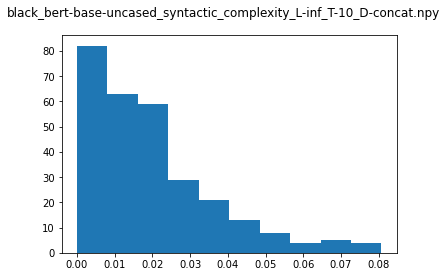


slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat.npy


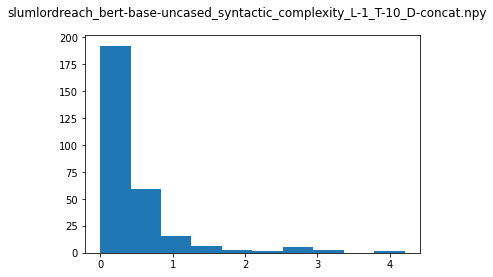


slumlordreach_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy


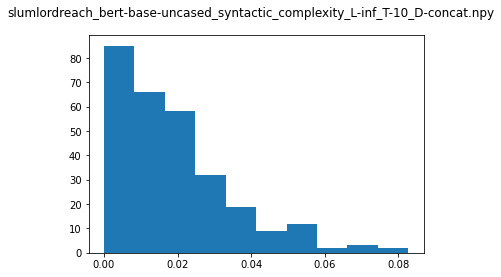


black_bert-base-uncased_syntactic_distance_T-10_D-concat.npy


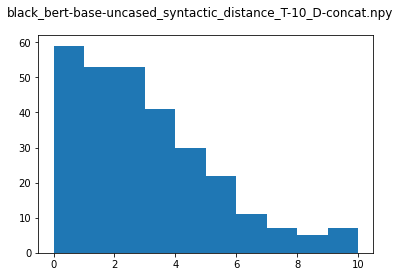

In [19]:
import glob

concat_metrics = [f for f in glob.glob("*.npy") if 'concat' in f and '20' not in f]

basic_stats = []

for concat_file in concat_metrics:
    
    concat = np.load(concat_file, allow_pickle=True)

    non_null = [c for c in concat if c is not None]
    
    magnitudes = [np.linalg.norm(x) for x in non_null]
    variance = np.var(magnitudes)
    basic_stats.append((concat_file, variance))
    
    stacked = np.stack(non_null)
    per_head_var = np.var(stacked, axis=0)
    
    print("\n"+concat_file + "\n=======")   
#     plt.hist(per_head_var.clip(0, 10))
    
#     plt.plot(magnitudes)
    plt.suptitle(concat_file)
    plt.show()

## Semantic Composition analysis

black_bert-base-uncased_semantic_composition_0-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 1.9799978381934662.


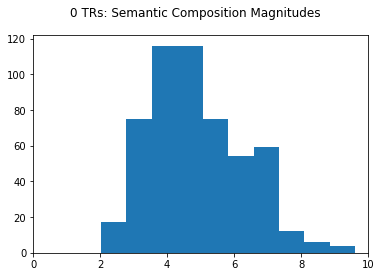

black_bert-base-uncased_semantic_composition_1-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.145171414527146.


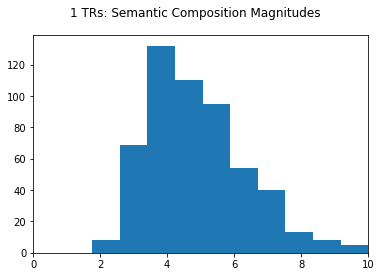

black_bert-base-uncased_semantic_composition_2-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.2385040690401907.


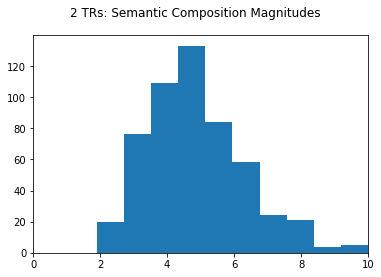

black_bert-base-uncased_semantic_composition_3-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.1975069305555075.


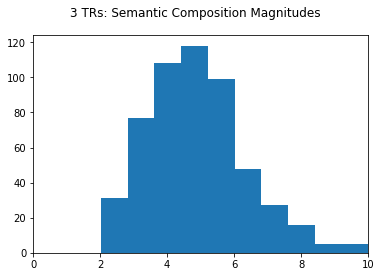

black_bert-base-uncased_semantic_composition_4-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.3883827223460754.


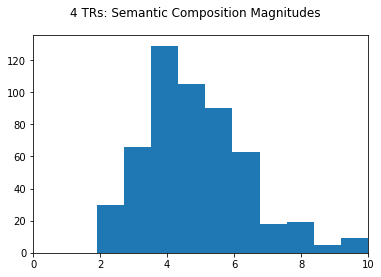

black_bert-base-uncased_semantic_composition_5-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.3763195838529674.


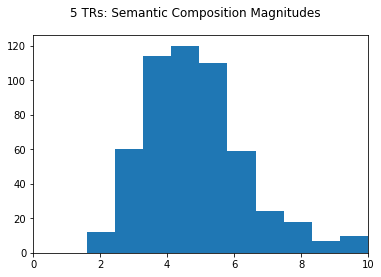

black_bert-base-uncased_semantic_composition_10-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.1992598972575834.


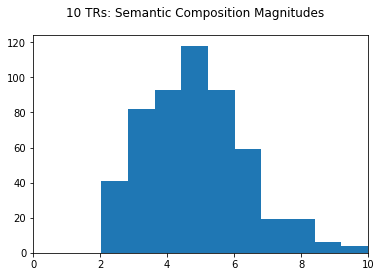

black_bert-base-uncased_semantic_composition_20-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.112018106891602.


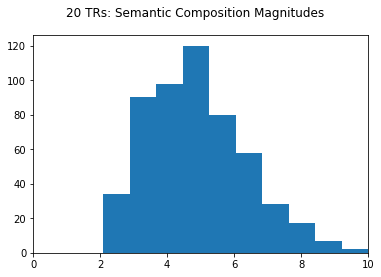

black_bert-base-uncased_semantic_composition_120-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.1634533860199383.


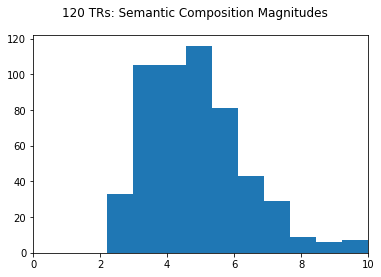

(1.5, 4.5)

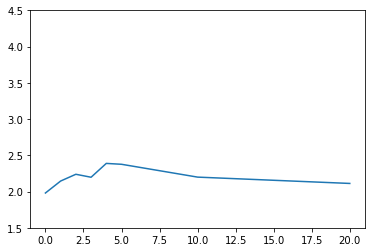

In [136]:
base_string = "{}_{}_semantic_composition_{}-TRs.npy"
composition_window_trs = [0, 1, 2, 3, 4, 5, 10, 20, 120]

basic_stats = []

for window in composition_window_trs:
    
    composition_file = base_string.format(STIMULUS, MODEL, window)
    
    composition = np.load(composition_file, allow_pickle=True)
    print("{}:\n\t{} numpy array.".format(composition_file, composition.shape))
    
    list_of_lists = [c[0] for c in composition if c is not None]
    print("\t{} non-null entries, each of length {}.".format(len(list_of_lists), len(list_of_lists[0])))
        
    magnitudes = [np.linalg.norm(x) for x in list_of_lists]
    variance = np.var(magnitudes)
    print("\tVariance of stimulus: {}.".format(variance))

    basic_stats.append((window, variance, magnitudes))
    plt.hist(np.clip(magnitudes, a_min=0, a_max=10))
    plt.xlim(0,10)
    plt.suptitle("{} TRs: Semantic Composition Magnitudes\n".format(window))
    plt.show()
    
plt.plot([s[0] for s in basic_stats[:-1]], [s[1] for s in basic_stats[:-1]])
plt.ylim(1.5, 4.5)
# for s in basic_stats:
#     print("{} TRs: variance {}".format(s[0], s[1]))

In [87]:
basic_stats[0]

for s in basic_stats:
    foo.stimulus_df["semantic_{}".format(s[0])] = s[2]

In [92]:
# All of the 10-magnitude semantic-0 windows are empty TRs
foo.stimulus_df.sort_values("semantic_0", ascending=False).head(10)

,tr,start_ts,end_ts,tr.1,phoneme_vector,n_phonemes,tokens,n_tokens,tr_shift,prev_tr,semantic_0,semantic_1,semantic_2,semantic_3,semantic_4,semantic_5,semantic_10,semantic_20,semantic_120
267,267,NaN,NaN,267,NaN,NaN,,0.0,NaN,NaN,10.12098,5.213956,5.473096,6.084009,5.190739,4.730173,4.988689,5.487190,4.454245
104,104,NaN,NaN,104,NaN,NaN,,0.0,NaN,NaN,10.12098,12.125739,4.694726,5.550145,5.242416,5.896296,5.381197,4.976490,5.274033
210,210,NaN,NaN,210,NaN,NaN,,0.0,NaN,NaN,10.12098,5.159545,4.753373,6.495642,6.687881,6.985307,5.887009,6.069081,7.913998
216,216,NaN,NaN,216,NaN,NaN,,0.0,NaN,NaN,10.12098,4.289599,4.268441,4.224968,4.476367,4.363392,4.066923,4.083075,5.868897
222,222,NaN,NaN,222,NaN,NaN,,0.0,NaN,NaN,10.12098,6.392119,6.122932,7.138283,6.700949,7.107169,6.929265,7.076125,6.705675
223,223,NaN,NaN,223,NaN,NaN,,0.0,NaN,NaN,10.12098,12.125739,6.820613,6.377802,7.479111,7.026903,6.984780,7.076125,6.575625
243,243,NaN,NaN,243,NaN,NaN,,0.0,NaN,NaN,10.12098,3.655644,4.741260,4.639576,4.809344,4.823622,5.060467,5.217996,4.374267
437,437,NaN,NaN,437,NaN,NaN,,0.0,NaN,NaN,10.12098,4.042264,3.358754,3.646273,4.755948,3.927987,4.919002,4.583480,4.796582
265,265,NaN,NaN,265,NaN,NaN,,0.0,NaN,NaN,10.12098,6.664588,6.720226,5.907961,6.054752,5.978247,5.668523,6.530249,5.453461
268,268,NaN,NaN,268,NaN,NaN,,0.0,NaN,NaN,10.12098,12.125739,5.473096,5.679229,6.300876,5.235856,5.361681,5.147768,4.661828


In [95]:
# All of the 12-magnitude semantic-0 windows are empty TRs
foo.stimulus_df.sort_values("semantic_4", ascending=False).head(10)[["tr", "tokens", "semantic_0", "semantic_1", "semantic_2", "semantic_4", "semantic_5"]]

,tr,tokens,semantic_0,semantic_1,semantic_2,semantic_4,semantic_5
288,288,,10.120980,12.125739,13.413522,15.059643,6.431725
108,108,,10.120980,12.125739,13.413522,15.059643,9.004570
107,107,,10.120980,12.125739,13.413522,15.059643,5.787079
197,197,And,4.139816,8.301531,10.230412,10.536220,11.502589
13,13,and,4.139816,5.632765,9.306528,10.483329,10.715409
140,140,as it turns out he,7.123513,7.826175,8.768817,9.150739,9.212953
299,299,recipes,5.397846,9.767514,9.870115,9.124095,8.804240
46,46,Missouri,7.400371,6.293546,7.659658,8.939651,9.050249
110,110,mind,4.934963,7.972274,8.236488,8.620571,8.769292
70,70,album,5.886784,7.823436,7.692533,8.461176,9.134628


black_bert-base-uncased_semantic_composition_0-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
[0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734]
black_bert-base-uncased_semantic_composition_1-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
[0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734]


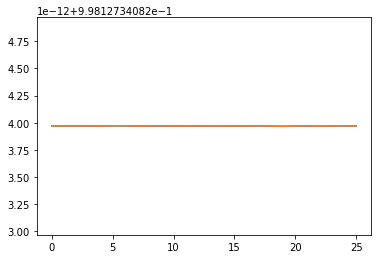

In [81]:
base_string = "{}_{}_semantic_composition_{}-TRs.npy"
composition_window_trs = [0, 1,]# 2, 3, 4, 5, 10, 20, 120]

basic_stats = []

for window in composition_window_trs:
    
    composition_file = base_string.format(STIMULUS, MODEL, window)
    
    composition = np.load(composition_file, allow_pickle=True)
    print("{}:\n\t{} numpy array.".format(composition_file, composition.shape))
    
    list_of_lists = [c[0] for c in composition if c is not None]
    print("\t{} non-null entries, each of length {}.".format(len(list_of_lists), len(list_of_lists[0])))
    
    # Concat into an actual NP array
    arr = np.array(list_of_lists)
    # Get variance for each location in array (so this will be a 26-width vector measuring variance)
    variance = np.var(arr, axis=0)

    print(variance)
    plt.plot(variance)
#     magnitudes = [np.linalg.norm(x) for x in list_of_lists]
#     print("\tVariance of stimulus: {}.".format(variance))

#     basic_stats.append((window, variance))
#     plt.hist(np.clip(magnitudes, a_min=0, a_max=10))
#     plt.xlim(0,10)
#     plt.suptitle("{} TRs: Semantic Composition Magnitudes\n".format(window))
#     plt.show()
    
    
# plt.plot([s[0] for s in basic_stats[:-1]], [s[1] for s in basic_stats[:-1]])
# for s in basic_stats:
#     print("{} TRs: variance {}".format(s[0], s[1]))